In [1]:
import os 
import cv2 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np 
from tensorflow.keras import layers
from scipy.io import loadmat
from tensorflow import keras
import tensorflow as tf 
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageFile
from PIL import ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
input_dir = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image2'
target_dir = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_mask3'
img_size = (512,512)
num_classes = 6
batch_size = 4

input_img_paths = sorted([os.path.join(input_dir,fname)
                         for fname in os.listdir(input_dir)
                         if fname.endswith('.jpg')])

target_img_paths = sorted([os.path.join(target_dir,fname)
                         for fname in os.listdir(target_dir)
                         if fname.endswith('.jpg') and not fname.startswith('.')])


In [4]:
class SkinDiseaseDataset(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img_to_array(img) / 255.  # input normalization
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            img = img_to_array(img) // 51  # 255 / 5 = 51으로 나누면 0~5 범위를 얻을 수 있습니다.
            y[j] = img

        return x, y

In [5]:
import random 
val_samples = 1200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = SkinDiseaseDataset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SkinDiseaseDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [6]:
x, y = train_gen[0]  # 첫 번째 배치 가져오기
print(x.shape, y.shape)
print(np.min(x), np.max(x), np.min(y), np.max(y)) 

(4, 512, 512, 3) (4, 512, 512, 1)
0.0 1.0 0 5


In [7]:
def convolution_block(block_input, num_filters=256, kernel_size=3, 
                     dilation_rate=1, padding='same', use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, 
                      dilation_rate=dilation_rate, padding='same', 
                      use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [8]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3]// x.shape[1], dims[-2]// x.shape[2]),
                                         interpolation='bilinear')(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    
    output = convolution_block(x, kernel_size=1)
    return output

In [9]:
def DeeplabV3(img_size, num_classes):
    model_input = keras.Input(shape=img_size + (3,))
    resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)
    
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = layers.UpSampling2D(size=(img_size[0] // 4 // x.shape[1],
                                       img_size[1] // 4 // x.shape[2]),
                                       interpolation='bilinear')(x)
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(img_size[0] // x.shape[1],
                                 img_size[1] // x.shape[2]),
                           interpolation='bilinear')(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1,1), padding='same')(x)
    
    return keras.Model(inputs=model_input, outputs=model_output)

In [10]:
model = DeeplabV3(img_size=img_size, num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
# Adam(learning_rate=0.0001) - DeeplabV3_segmentation1
# Adam(learning_rate=1e-6) - DeeplabV3_segmentation2
# RMSprop(learning_rate=1e-6) - DeeplabV3_segmentation3
# RMSprop(learning_rate=0.0001) - DeeplabV3_segmentation4

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=1e-6), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=RMSprop(learning_rate=1e-6), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint('DeeplabV3_segmentation_3.h5', save_best_only=True)]

epochs = 10

In [13]:
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
2700/2700 [==============================] - 443s 160ms/step - loss: 0.1443 - accuracy: 0.9913 - val_loss: 0.1000 - val_accuracy: 0.9998


C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2700/2700 [==============================] - 431s 160ms/step - loss: 0.0770 - accuracy: 0.9999 - val_loss: 0.0723 - val_accuracy: 1.0000
Epoch 3/10
2700/2700 [==============================] - 432s 160ms/step - loss: 0.0699 - accuracy: 0.9998 - val_loss: 0.1104 - val_accuracy: 0.9988
Epoch 4/10
2700/2700 [==============================] - 429s 159ms/step - loss: 0.0648 - accuracy: 0.9997 - val_loss: 0.0625 - val_accuracy: 0.9998
Epoch 5/10
2700/2700 [==============================] - 430s 159ms/step - loss: 0.0651 - accuracy: 0.9998 - val_loss: 0.1172 - val_accuracy: 0.9753
Epoch 6/10
2700/2700 [==============================] - 433s 160ms/step - loss: 0.0616 - accuracy: 0.9994 - val_loss: 0.0656 - val_accuracy: 0.9992
Epoch 7/10
2700/2700 [==============================] - 444s 164ms/step - loss: 0.0600 - accuracy: 0.9993 - val_loss: 0.0591 - val_accuracy: 0.9993
Epoch 8/10
2700/2700 [==============================] - 441s 163ms/step - loss: 0.0560 - accuracy: 0.9987 - val_

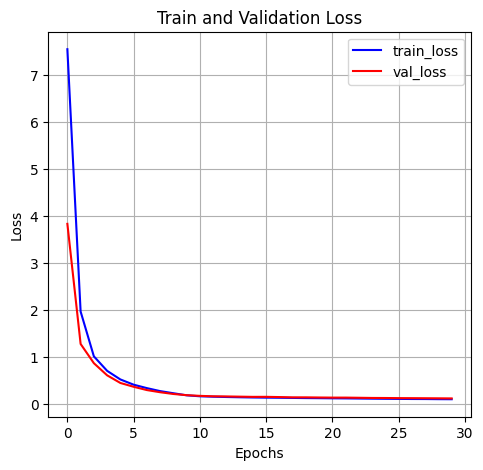

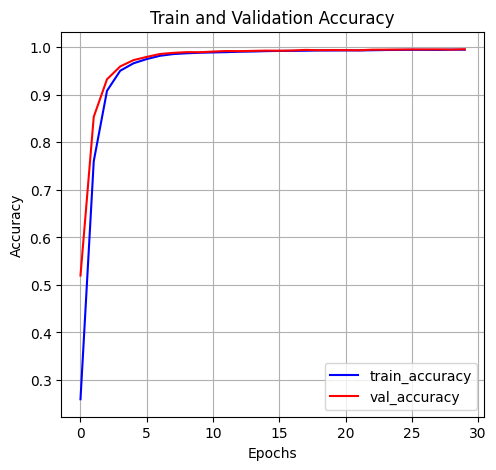

In [13]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

fig = plt.figure(figsize=(12,5))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(loss, color='blue', label='train_accuracy')
ax2.plot(val_loss, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [18]:
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    # Scale up the values in mask for better visibility
    mask *= 255 // num_classes
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize((512, 512)) # Resize predicted mask to 320x320
    return np.array(img)
    
i = 30

fig, ax = plt.subplots(1, 3, figsize=(10, 10))

# Original Image
ax[0].imshow(load_img(val_input_img_paths[i], target_size=(512, 512)))  # Resize to 320x320
ax[0].set_title('Original Image')

# Mask Image
ax[1].imshow(PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i], target_size=(512, 512))))  # Resize to 320x320
ax[1].set_title('Mask Image')

# Predicted Mask
ax[2].imshow(display_mask(i))
ax[2].set_title('Predicted Mask')

plt.show()

ResourceExhaustedError:  OOM when allocating tensor with shape[4,256,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_9/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_80373]

Function call stack:
predict_function
